In [1]:
# import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, HTML

<style>
    body {
        margin: 10px;
        padding: 0;
    }

    #notebook-container {
        max-width: 1000px; /* limits the page from appearing too wide */
        margin: auto; /* center */
    }
</style>

<link rel="stylesheet" href="static/css/style.css">

<h2 id="title" style="text-align: center; width: 80%;">Exploratory Data Analysis</h2>

<hr>

<link rel="stylesheet" href="static/css/style.css">

<div class="button">
    <a href="index.html">Go to Home Page</a>
</div>

- [Total Spending per Month](#total-spending-per-month)
- [Spend per Category per Month](#spend-per-category-per-month)
- [Amount per Person](#amount-per-person)
- [Individual Expenses](#individual-expenses)
- [Tables](#tables)
- [Treemap of Categories](#treemap-of-categories)

<br>

<p id="title" style="text-align: center;">Mobile users!<br>Landscape mode is your friend</p>

In [2]:
# """
# (with code cells:)
# jupyter nbconvert --to html --execute utilities_313_EDA.ipynb

# (without code cells:)
# jupyter nbconvert --to html --execute --TemplateExporter.exclude_input=True utilities_313_EDA.ipynb
# """

In [3]:
df = pd.read_csv("./resources/utilities_313.csv")

# convert Date to datetime
df.Date = pd.to_datetime(df.Date)

#####################
#####################
# drop most recent, incomplete month (March 2025)
# df = df[~((df["Date"].dt.year == 2025) & (df["Date"].dt.month == 3))]

# dynamically remove the most recent month
most_recent_date = df["Date"].max()
df = df[
    ~(
        (df["Date"].dt.year == most_recent_date.year)
        & (df["Date"].dt.month == most_recent_date.month)
    )
]
#####################
#####################

# df.describe()

In [4]:
# calculate total amount spent
total_spent = df["Amount"].sum()

# calculate total amount per person
total_per_person = total_spent / 3

# get min and max dates
min_date = df["Date"].min().strftime("%B %Y")
max_date = df["Date"].max().strftime("%B %Y")

# create markdown text
html_text = f"""
<h1 style="text-align: center;"><u>Summary</u></h1>
<p><strong>Total Amount spent:</strong> ${total_spent:,.2f}</p>
<p><strong>Total Amount per Person:</strong> ${total_per_person:,.2f}</p>
<p><strong>Date Range:</strong> {min_date} - {max_date}</p>
"""

# Display as HTML
display(HTML(html_text))

<a id="data-assumptions"></a>
## <u>Data Assumptions</u>

As part of switching between electric companies, June of 2023 charged an unusally high amount after shortchanging the prior month. At <a href="#data-change">this point</a> in the analysis, in just a few short plots, I will move some of that money from June to May of 2023 to more accurately reflect what billing should have been.

At the same point, I will consolidate "Pepco" and "CleanChoice" into one creatively-named value, "Electric". Accounting wizardry.

In the same spirit of data fidelity to truthiness, I <a href="https://github.com/johbry17/utilities-313/blob/main/resources/extract_data.ipynb">manually updated</a> December 2023 through April 2024, to account for the weird stretch where the utility company only billed $19/month and created a giant backlog of debt that had to be paid off.

Some days, you're just on hold with the Electric company.

<a id="total-spending-per-month"></a>
## Total Spending per Month
<hr>

[Back to Top](#)

In [5]:
# group by Date and sum Amount
monthly_amount = df.resample("M", on="Date")["Amount"].sum().reset_index()

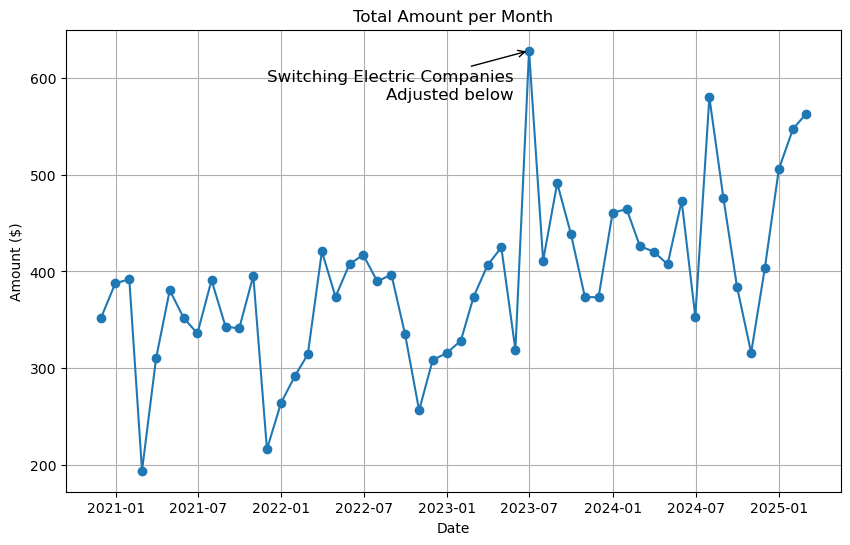

In [6]:
# plot
plt.figure(figsize=(10, 6))
plt.plot(monthly_amount["Date"], monthly_amount["Amount"], marker="o")
plt.title("Total Amount per Month")
plt.xlabel("Date")
plt.ylabel("Amount ($)")
plt.grid(True)

# Add annotation at June 2023
annot_date = pd.Timestamp("2023-06-30")
annot_value = monthly_amount.loc[monthly_amount["Date"] == annot_date, "Amount"].values[
    0
]

plt.annotate(
    "Switching Electric Companies   \nAdjusted below   ",
    xy=(annot_date, annot_value),
    xytext=(annot_date, annot_value - 50),  # Adjust text position
    arrowprops=dict(facecolor="black", arrowstyle="->"),
    fontsize=12,
    ha="right",
)

plt.show()

<hr>

In [7]:
# plot
fig = px.bar(
    monthly_amount,
    x="Date",
    y="Amount",
    title="Monthy Total Amount",
    labels={"Date": "Month and Year", "Amount": "Amount ($)"},
)

# format y-axis to show currency
fig.update_traces(hovertemplate="Month and Year: %{x}<br>Amount: $%{y:.2f}")

# format for mobile
fig.update_layout(
    xaxis=dict(title=""),
    yaxis=dict(
        title="",
        tickprefix="$",
    ),
    margin=dict(
        t=40,
        b=30,
        l=10,
        r=10,
    ),
    legend=dict(
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2,
    ),
)

fig.show()

<hr>

In [8]:
# line plot
fig = px.line(
    monthly_amount,
    x="Date",
    y="Amount",
    title="Monthy Total Amount",
    labels={"Date": "Month and Year", "Amount": "Amount ($)"},
)

# format y-axis to show currency
fig.update_traces(hovertemplate="Month and Year: %{x}<br>Amount: $%{y:.2f}")

# format for mobile
fig.update_layout(
    xaxis=dict(title=""),
    yaxis=dict(
        title="",
        tickprefix="$",
    ),
    margin=dict(
        t=40,
        b=30,
        l=10,
        r=10,
    ),
    legend=dict(
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2,
    ),
)

fig.show()

In [9]:
# df.Expense.unique()

<a id="spend-per-category-per-month"></a>
## Bill per Category per Month
<hr>

[Back to Top](#)

This is the only time you'll see the Pepco / CleanChoice data. After this, they'll be consolidated into "Electric"

In [10]:
# group by year, month, and expense type, then sum Amount
monthly_expense_amount = (
    df.groupby([df["Date"].dt.to_period("M"), "Expense"])["Amount"].sum().reset_index()
)
monthly_expense_amount["Date"] = monthly_expense_amount["Date"].astype(
    str
)  # convert to string for Plotly

# plot
fig = px.line(
    monthly_expense_amount,
    x="Date",
    y="Amount",
    color="Expense",
    title="Monthly Expenses<br>w/ CleanChoice & Pepco",
    labels={
        "Date": "Month and Year",
        "Amount": "Amount ($)",
        "Expense": "",
    },
    hover_data={"Expense": True},
)

# format y-axis to show currency
fig.update_traces(
    hovertemplate="Month and Year: %{x}<br>Amount: $%{y:.2f}<br>Expense Type: %{customdata}"
)

# format for mobile
fig.update_layout(
    xaxis=dict(title=""),
    yaxis=dict(
        title="",
        tickprefix="$",
    ),
    margin=dict(
        t=40,
        b=30,
        l=10,
        r=10,
    ),
    legend=dict(
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2,
    ),
)


fig.show()

<a id="data-change"></a>
#### Data Change

Here is where I consolidate CleanChoice and Pepco into "Electric". I also pull a sneaky trick and move $143.50 from June 2023 to May 2023. See [intro](#data-assumptions).

In [11]:
# IMPORTANT TOGGLE
# Adjusting the Electric expenses for June 2023 and May 2023
#########
# accounting for the CleanChoice debacle

# adjust the Electric expenses for June 2023 and May 2023
# Subtract 143.5 from June 2023, Electric
df.loc[
    (df["Year"] == 2023) & (df["Month"] == 6) & (df["Expense"] == "CleanChoice"),
    "Amount",
] -= 143.5

# Add 143.5 to May 2023, Electric
df.loc[
    (df["Year"] == 2023) & (df["Month"] == 5) & (df["Expense"] == "Pepco"), "Amount"
] += 143.5

In [12]:
# IMPORTANT TOGGLE
# Consolidating Electric Expenses
#########
# from CleanChoice and Pepco

# change "Pepco" and "CleanChoice" to "Electric" in the Expense column
df.loc[
    (df["Expense"] == "Pepco") | (df["Expense"] == "CleanChoice"), "Expense"
] = "Electric"
# df.Expense.unique()

<hr>

In [13]:
# group by year, month, and expense type, then sum Amount
monthly_expense_amount = (
    df.groupby([df["Date"].dt.to_period("M"), "Expense"])["Amount"].sum().reset_index()
)
monthly_expense_amount["Date"] = monthly_expense_amount["Date"].astype(
    str
)  # convert to string for Plotly

# plot
fig = px.line(
    monthly_expense_amount,
    x="Date",
    y="Amount",
    color="Expense",
    title="Monthly Expenses",
    labels={
        "Date": "Month and Year",
        "Amount": "Amount ($)",
        "Expense": "",
    },
    hover_data={"Expense": True},
)

# format y-axis to show currency
fig.update_traces(
    hovertemplate="Month and Year: %{x}<br>Amount: $%{y:.2f}<br>Expense Type: %{customdata}"
)


# format for mobile
fig.update_layout(
    xaxis=dict(title=""),
    yaxis=dict(
        title="",
        tickprefix="$",
    ),
    margin=dict(
        t=40,
        b=30,
        l=10,
        r=10,
    ),
    legend=dict(
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2,
    ),
)

fig.show()

<hr>

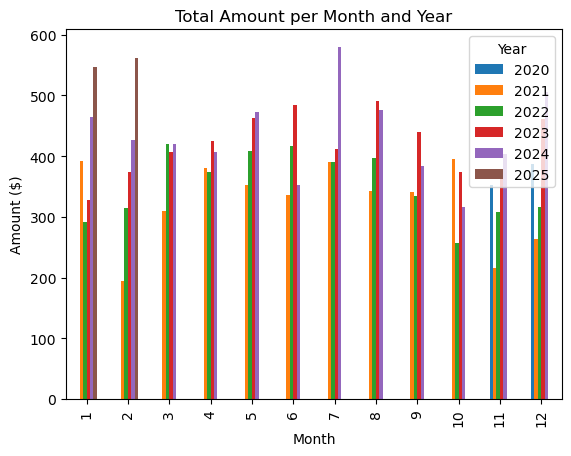

In [14]:
# group by year and month, sum Amount
monthly_amount = df.groupby(["Year", "Month"])["Amount"].sum().reset_index()

# pivot
monthly_amount_pivot = monthly_amount.pivot(
    index="Month", columns="Year", values="Amount"
)

# plot
# plt.figure(figsize=(10, 6))
monthly_amount_pivot.plot(kind="bar")
plt.title("Total Amount per Month and Year")
plt.xlabel("Month")
plt.ylabel("Amount ($)")
plt.legend(title="Year")
plt.show()

# suppressing output warning <Figure size 1000x600 with 0 Axes>
plt.close()

<hr>

In [15]:
# convert to Plotly format
monthly_amount_pivot = monthly_amount_pivot.reset_index()

# create traces, one for each year
traces = []
for year in monthly_amount_pivot.columns[1:]:
    traces.append(
        go.Bar(
            x=monthly_amount_pivot["Month"],
            y=monthly_amount_pivot[year],
            name=str(year),
            hovertemplate="Month: %{x}<br>Amount: $%{y:.2f}<br>Year: " + str(year),
        )
    )

# create fig
fig = go.Figure(data=traces)

# update layout
fig.update_layout(
    barmode="group",
    title="Total Monthly Bills,<br>Color-Coded by Year",
    xaxis=dict(
        tickmode="array",
        tickvals=list(range(1, 13)),
        ticktext=[
            "Jan",
            "Feb",
            "Mar",
            "Apr",
            "May",
            "Jun",
            "Jul",
            "Aug",
            "Sep",
            "Oct",
            "Nov",
            "Dec",
        ],
        title="Month",
    ),
    yaxis=dict(title="Amount ($)"),
    legend_title_text="",
)

# format for mobile
fig.update_layout(
    xaxis=dict(title=""),
    yaxis=dict(
        title="",
        tickprefix="$",
    ),
    margin=dict(
        t=40,
        b=30,
        l=10,
        r=10,
    ),
    legend=dict(
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2,
    ),
)

# plot
fig.show()

<a id="amount-per-person"></a>
## Bill per Person
<hr>

[Back to Top](#)

In [16]:
# group by year and month, sum Amount
monthly_amount = df.groupby(df["Date"].dt.to_period("M"))["Amount"].sum().reset_index()
monthly_amount["Date"] = monthly_amount["Date"].astype(
    str
)  # convert to string for Plotly

# calculate amount per person
monthly_amount["Amount_per_person"] = monthly_amount["Amount"] / 3

# plot
fig = px.line(
    monthly_amount,
    x="Date",
    y="Amount_per_person",
    title="Monthly Bill <b>per Person</b>",
    labels={"Date": "Month and Year", "Amount_per_person": "Amount per Person ($)"},
)

# format y-axis to show currency
fig.update_traces(hovertemplate="Month and Year: %{x}<br>Amount per Person: $%{y:.2f}")

# format for mobile
fig.update_layout(
    xaxis=dict(title=""),
    yaxis=dict(
        title="",
        tickprefix="$",
    ),
    margin=dict(
        t=40,
        b=30,
        l=10,
        r=10,
    ),
    legend=dict(
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2,
    ),
)

fig.show()

<hr>

In [17]:
# group by year and month, sum Amount
monthly_amount = df.groupby(df["Date"].dt.to_period("M"))["Amount"].sum().reset_index()
monthly_amount["Date"] = monthly_amount["Date"].astype(
    str
)  # convert to string for Plotly

# calculate amount per person
monthly_amount["Amount_per_person"] = monthly_amount["Amount"] / 3

# plot
fig = px.bar(
    monthly_amount,
    x="Date",
    y="Amount_per_person",
    title="Monthly Bill <b>per Person</b>",
    labels={"Date": "Month and Year", "Amount_per_person": "Amount per Person ($)"},
)

# format y-axis to show currency
fig.update_traces(hovertemplate="Month and Year: %{x}<br>Amount per Person: $%{y:.2f}")

# format for mobile
fig.update_layout(
    xaxis=dict(title=""),
    yaxis=dict(
        title="",
        tickprefix="$",
    ),
    margin=dict(
        t=40,
        b=30,
        l=10,
        r=10,
    ),
    legend=dict(
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2,
    ),
)

fig.show()

<hr>

In [18]:
monthly_amount.describe()

,Amount,Amount_per_person
count,52.000000,52.000000
mean,389.041538,129.680513
std,79.642766,26.547589
min,194.000000,64.666667
25%,339.865000,113.288333
50%,390.305000,130.101667
75%,425.167500,141.722500
max,579.930000,193.310000


<hr>

In [19]:
# group by Year and Month, then sum Amount
monthly_amount = df.groupby(["Year", "Month"])["Amount"].sum().reset_index()

# calculate amount per person
monthly_amount["Amount_per_person"] = monthly_amount["Amount"] / 3

# plot
fig = px.line(
    monthly_amount,
    x="Month",
    y="Amount_per_person",
    color="Year",
    title="Individual Years <b>per Person</b>",
    labels={
        "Month": "Month",
        "Amount_per_person": "Amount per Person ($)",
        "Year": "",
    },
)

# update x-axis to show month names
fig.update_layout(
    xaxis=dict(
        tickmode="array",
        tickvals=list(range(1, 13)),
        ticktext=[
            "Jan",
            "Feb",
            "Mar",
            "Apr",
            "May",
            "Jun",
            "Jul",
            "Aug",
            "Sep",
            "Oct",
            "Nov",
            "Dec",
        ],
    )
)

# format y-axis to show currency
fig.update_traces(hovertemplate="Month: %{x}<br>Amount per Person: $%{y:.2f}")


# format for mobile
fig.update_layout(
    xaxis=dict(title=""),
    yaxis=dict(
        title="",
        tickprefix="$",
    ),
    margin=dict(
        t=40,
        b=30,
        l=10,
        r=10,
    ),
    legend=dict(
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2,
    ),
)

fig.show()

<hr>

In [20]:
# group by year and month, sum Amount
monthly_amount = df.groupby(["Year", "Month"])["Amount"].sum().reset_index()

# calculate amount per person
monthly_amount["Amount_per_person"] = monthly_amount["Amount"] / 3

# pivot
monthly_amount_pivot = monthly_amount.pivot(
    index="Month", columns="Year", values="Amount_per_person"
)

# convert to Plotly format
monthly_amount_pivot = monthly_amount_pivot.reset_index()

# create traces, one for each year
traces = []
for year in monthly_amount_pivot.columns[1:]:
    traces.append(
        go.Bar(
            x=monthly_amount_pivot["Month"],
            y=monthly_amount_pivot[year],
            name=str(year),
            hovertemplate="Month: %{x}<br>Amount per Person: $%{y:.2f}<br>Year: "
            + str(year),
        )
    )

# create fig
fig = go.Figure(data=traces)

# update layout
fig.update_layout(
    barmode="group",
    title="Monthly Bills <b>per Person</b><br>Color-Coded by Year",
    xaxis=dict(
        tickmode="array",
        tickvals=list(range(1, 13)),
        ticktext=[
            "Jan",
            "Feb",
            "Mar",
            "Apr",
            "May",
            "Jun",
            "Jul",
            "Aug",
            "Sep",
            "Oct",
            "Nov",
            "Dec",
        ],
        title="Month",
    ),
    yaxis=dict(title="Amount per Person ($)"),
    legend_title_text="",
)

# format for mobile
fig.update_layout(
    xaxis=dict(title=""),
    yaxis=dict(
        title="",
        tickprefix="$",
    ),
    margin=dict(
        t=40,
        b=30,
        l=10,
        r=10,
    ),
    legend=dict(
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2,
    ),
)

# plot
fig.show()

<hr>

In [21]:
# group by year, month, and expense type, then sum Amount
monthly_expense_amount = (
    df.groupby(["Year", "Month", "Expense"])["Amount"].sum().reset_index()
)

# calculate amount per person
monthly_expense_amount["Amount_per_person"] = monthly_expense_amount["Amount"] / 3

# filter for only complete recent years
# so that the chart isn't distorted by the current incomplete year
# which would visually appear as a significant drop or increase in expenses
# get min and max months
min_year = monthly_expense_amount["Year"].min()
min_month = monthly_expense_amount.loc[
    monthly_expense_amount["Year"] == min_year, "Month"
].min()
max_year = monthly_expense_amount["Year"].max()
max_month = monthly_expense_amount.loc[
    monthly_expense_amount["Year"] == max_year, "Month"
].max()

# get total number of months
total_months = (max_year - min_year) * 12 + (max_month - min_month + 1)

# get number of complete years
complete_years = total_months // 12

# get starting year and month for complete years
start_year = max_year - complete_years
start_month = max_month + 1 if max_month < 12 else 1

# filter for complete years
filtered_data = monthly_expense_amount[
    (monthly_expense_amount["Year"] > start_year)
    | (
        (monthly_expense_amount["Year"] == start_year)
        & (monthly_expense_amount["Month"] >= start_month)
    )
]

# pivot
monthly_expense_pivot = filtered_data.pivot_table(
    index=["Year", "Month"], columns="Expense", values="Amount_per_person", fill_value=0
)

# reorder expense columns
expense_order = ["Gas", "Internet", "Cleaning", "Electric"]
monthly_expense_pivot = monthly_expense_pivot[expense_order]

# convert pivoted DataFrame to a format suitable for Plotly
monthly_expense_pivot = monthly_expense_pivot.reset_index()

# create traces, one for each expense type
traces = []
for expense in monthly_expense_pivot.columns[2:]:
    traces.append(
        go.Bar(
            x=monthly_expense_pivot["Month"],
            y=monthly_expense_pivot[expense],
            name=expense,
            hovertemplate="Month: %{x} %{customdata[0]}<br>Amount per Person: $%{y:.2f}<br>Expense: "
            + expense,
            customdata=monthly_expense_pivot[["Year"]].values,
        )
    )

# create fig
fig = go.Figure(data=traces)

# update layout
fig.update_layout(
    barmode="stack",
    title=f"Month and Year Total Stacked<br><b>per Person</b> Last {complete_years} Years<br>Color-Coded by Expense",
    xaxis=dict(
        tickmode="array",
        tickvals=list(range(1, 13)),
        ticktext=[
            "Jan",
            "Feb",
            "Mar",
            "Apr",
            "May",
            "Jun",
            "Jul",
            "Aug",
            "Sep",
            "Oct",
            "Nov",
            "Dec",
        ],
        title="Month",
    ),
    yaxis=dict(title="Amount per Person ($)"),
    legend_title_text="",
)

# format for mobile
fig.update_layout(
    xaxis=dict(title=""),
    yaxis=dict(
        title="",
        tickprefix="$",
    ),
    margin=dict(
        t=80,
        b=30,
        l=10,
        r=10,
    ),
    legend=dict(
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2,
    ),
)

# plot
fig.show()

<hr>

In [22]:
# group by Date and Expense, then sum Amount
monthly_expense = df.groupby(["Date", "Expense"])["Amount"].sum().reset_index()

# calculate amount per person
monthly_expense["Amount_per_person"] = monthly_expense["Amount"] / 3

# define stacking order
expense_order = ["Gas", "Internet", "Cleaning", "Electric"]

# create traces for each expense type
traces = []
for expense in expense_order:
    filtered_data = monthly_expense[monthly_expense["Expense"] == expense]
    traces.append(
        go.Bar(
            x=filtered_data["Date"],
            y=filtered_data["Amount_per_person"],
            name=expense,
            hovertemplate="Date: %{x}<br>Expense: "
            + expense
            + "<br>Amount per Person: $%{y:.2f}",
        )
    )

# create figure
fig = go.Figure(data=traces)

# format for mobile
fig.update_layout(
    barmode="stack",  # stack expenses within each date bar
    title="Bill <b>per Person</b><br>Stacked by Expense",
    legend_title_text="",
    xaxis=dict(title=""),
    yaxis=dict(
        title="",
        tickprefix="$",
    ),
    margin=dict(
        t=40,
        b=30,
        l=10,
        r=10,
    ),
    legend=dict(
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2,
    ),
)

# plot
fig.show()

<a id="individual-expenses"></a>
## Individual Expenses
<hr>

[Back to Top](#)

In [23]:
# define default Plotly colors for each expense type
expense_colors = {
    "Gas": "#636EFA",  # blue
    "Internet": "#EF553B",  # red
    "Cleaning": "#00CC96",  # green
    "Electric": "#AB63FA",  # purple
}

# set y-axis range for all individual expense plots
yaxis_range = [0, max(monthly_expense["Amount_per_person"])]

In [24]:
# # plot individual expense types with the extracted colors, line charts
# for expense in expense_order:
#     filtered_data = (
#         df[df["Expense"] == expense].groupby("Date")["Amount"].sum().reset_index()
#     )
#     filtered_data["Amount_per_person"] = filtered_data["Amount"] / 3

#     fig_expense = go.Figure()
#     fig_expense.add_trace(
#         go.Scatter(
#             x=filtered_data["Date"],
#             y=filtered_data["Amount_per_person"],
#             mode="lines+markers",
#             name=expense,
#             marker=dict(color=expense_colors[expense]),  # Use the extracted color
#             hovertemplate="Date: %{x}<br>Amount per Person: $%{y:.2f}",
#         )
#     )

#     fig_expense.update_layout(
#         title=f"{expense} Expense Over Time per Person (Line Plot)",
#         xaxis=dict(title="Date", tickformat="%b %Y", tickangle=-45),
#         yaxis=dict(title="Amount per Person ($)", range=yaxis_range),
#     )

#     # show the individual expense plot
#     fig_expense.show()

In [25]:
# filter Electric
electric_expense = (
    df[df["Expense"] == "Electric"].groupby("Date")["Amount"].sum().reset_index()
)

# calculate amount per person
electric_expense["Amount_per_person"] = electric_expense["Amount"] / 3

# plot
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=electric_expense["Date"],
        y=electric_expense["Amount_per_person"],
        name="Electric",
        marker=dict(color=expense_colors["Electric"]),
        hovertemplate="Date: %{x}<br>Amount per Person: $%{y:.2f}",
    )
)

# format for mobile
fig.update_layout(
    title="Electric<br><b>per Person</b>",
    xaxis=dict(title=""),
    yaxis=dict(
        title="",
        tickprefix="$",
        range=yaxis_range,
    ),
    margin=dict(
        t=40,
        b=30,
        l=10,
        r=10,
    ),
    legend=dict(
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2,
    ),
)

fig.show()

<hr>


In [26]:
# filter Cleaning
cleaning_expense = (
    df[df["Expense"] == "Cleaning"].groupby("Date")["Amount"].sum().reset_index()
)

# calculate amount per person
cleaning_expense["Amount_per_person"] = cleaning_expense["Amount"] / 3

# plot
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=cleaning_expense["Date"],
        y=cleaning_expense["Amount_per_person"],
        name="Cleaning",
        marker=dict(color=expense_colors["Cleaning"]),
        hovertemplate="Date: %{x}<br>Amount per Person: $%{y:.2f}",
    )
)

fig.update_layout(
    title="Cleaning<br><b>per Person</b>",
    xaxis=dict(title="Date", tickformat="%b %Y", tickangle=-45),
    yaxis=dict(title="Amount per Person ($)", range=yaxis_range),
)

# format for mobile
fig.update_layout(
    xaxis=dict(title=""),
    yaxis=dict(
        title="",
        tickprefix="$",
    ),
    margin=dict(
        t=80,
        b=30,
        l=10,
        r=10,
    ),
    legend=dict(
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2,
    ),
)

fig.show()

<hr>


In [27]:
# filter Internet
internet_expense = (
    df[df["Expense"] == "Internet"].groupby("Date")["Amount"].sum().reset_index()
)

# calculate amount per person
internet_expense["Amount_per_person"] = internet_expense["Amount"] / 3

# plot
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=internet_expense["Date"],
        y=internet_expense["Amount_per_person"],
        name="Internet",
        marker=dict(color=expense_colors["Internet"]),
        hovertemplate="Date: %{x}<br>Amount per Person: $%{y:.2f}",
    )
)

fig.update_layout(
    title="Internet<br><b>per Person</b>",
    xaxis=dict(title="Date", tickformat="%b %Y", tickangle=-45),
    yaxis=dict(title="Amount per Person ($)", range=yaxis_range),
)

# format for mobile
fig.update_layout(
    xaxis=dict(title=""),
    yaxis=dict(
        title="",
        tickprefix="$",
    ),
    margin=dict(
        t=80,
        b=30,
        l=10,
        r=10,
    ),
    legend=dict(
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2,
    ),
)

fig.show()

<hr>


In [28]:
# filter Gas
gas_expense = df[df["Expense"] == "Gas"].groupby("Date")["Amount"].sum().reset_index()

# calculate amount per person
gas_expense["Amount_per_person"] = gas_expense["Amount"] / 3

# plot
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=gas_expense["Date"],
        y=gas_expense["Amount_per_person"],
        name="Gas",
        marker=dict(color=expense_colors["Gas"]),
        hovertemplate="Date: %{x}<br>Amount per Person: $%{y:.2f}",
    )
)

fig.update_layout(
    title="Gas<br><b>per Person</b>",
    xaxis=dict(title="Date", tickformat="%b %Y", tickangle=-45),
    yaxis=dict(title="Amount per Person ($)", range=yaxis_range),
)

# format for mobile
fig.update_layout(
    xaxis=dict(title=""),
    yaxis=dict(
        title="",
        tickprefix="$",
    ),
    margin=dict(
        t=80,
        b=30,
        l=10,
        r=10,
    ),
    legend=dict(
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2,
    ),
)

fig.show()

<hr>


In [29]:
# ignore this
df_filtered = df

# filter for Electric
df_electric = df_filtered[df_filtered["Expense"] == "Electric"]

# group by Year, Month, and Expense, then sum Amount
monthly_expense = (
    df_electric.groupby(["Year", "Month", "Expense"])["Amount"].sum().reset_index()
)

# group by Month and calculate the average Amount for Electric
average_monthly_expense = (
    monthly_expense.groupby("Month")["Amount"].mean().reset_index()
)
average_monthly_expense.columns = ["Month", "Average Amount"]

# create chart
fig = px.bar(
    average_monthly_expense,
    x="Month",
    y="Average Amount",
    title="Average Monthly Electric Bill",
    labels={"Month": "Month", "Average Amount": "Average Amount ($)"},
)

fig.update_layout(
    xaxis=dict(
        tickmode="array",
        tickvals=list(range(1, 13)),
        ticktext=[
            "Jan",
            "Feb",
            "Mar",
            "Apr",
            "May",
            "Jun",
            "Jul",
            "Aug",
            "Sep",
            "Oct",
            "Nov",
            "Dec",
        ],
    ),
    title_x=0.5,
)

fig.update_traces(hovertemplate="Month: %{x}<br>Average Amount: $%{y:.2f}")

# format for mobile
fig.update_layout(
    xaxis=dict(title=""),
    yaxis=dict(
        title="",
        tickprefix="$",
    ),
    margin=dict(
        t=80,
        b=30,
        l=10,
        r=10,
    ),
    legend=dict(
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2,
    ),
)

# plot
fig.show()

<a id="tables"></a>
## Tables
<hr>

[Back to Top](#)

In [30]:
# drop 2020 (only two months of data)
# drop 2020, .copy() to avoid SettingWithCopyWarning
df_filtered = df[(df["Date"].dt.year >= 2021)].copy()

# calculate amount per person
df_filtered["Amount_per_person"] = df_filtered["Amount"] / 3

# group by year and month, sum Amount per Person
monthly_stats = (
    df_filtered.groupby(["Year", "Month"])["Amount_per_person"].sum().reset_index()
)
monthly_stats.columns = ["Year", "Month", "Total Amount per Person"]

# group by year and calculate max, min, and average of monthly sums
yearly_stats = (
    monthly_stats.groupby("Year")["Total Amount per Person"]
    .agg(["max", "min", "mean"])
    .reset_index()
)
yearly_stats.columns = [
    "Year",
    "Max Amount per Person",
    "Min Amount per Person",
    "Average Amount per Person",
]

# create table
fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=[
                    "Year",
                    "Max Amount per Person",
                    "Min Amount per Person",
                    "Average Amount per Person",
                ],
                fill_color="paleturquoise",
                align="left",
            ),
            cells=dict(
                values=[
                    yearly_stats["Year"],
                    yearly_stats["Max Amount per Person"].map("${:,.2f}".format),
                    yearly_stats["Min Amount per Person"].map("${:,.2f}".format),
                    yearly_stats["Average Amount per Person"].map("${:,.2f}".format),
                ],
                fill_color="lavender",
                align="left",
            ),
        )
    ]
)

# update layout
fig.update_layout(
    title={
        "text": "Max, Min, and Avg Monthly<br><b>per Person</b></sup>",
        "x": 0.5,
        "xanchor": "center",
    }
)

# format for mobile
fig.update_layout(
    xaxis=dict(title=""),
    yaxis=dict(
        title="",
        tickprefix="$",
    ),
    margin=dict(
        t=80,
        b=0,
        l=10,
        r=10,
    ),
    height=300,
    legend=dict(
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2,
    ),
)

# plot
fig.show()

<hr>


In [31]:
# filter Electric
df_electric = df[df["Expense"] == "Electric"]

# drop 2020, .copy() to avoid SettingWithCopyWarning
df_filtered = df_electric[(df_electric["Date"].dt.year >= 2021)].copy()

# calculate amount per person
df_filtered["Amount_per_person"] = df_filtered["Amount"] / 3

# group by year and month, then sum Amount per Person
monthly_stats = (
    df_filtered.groupby(["Year", "Month"])["Amount_per_person"].sum().reset_index()
)
monthly_stats.columns = ["Year", "Month", "Total Amount per Person"]

# group by year and calculate max, min, and average of monthly sums
yearly_stats = (
    monthly_stats.groupby("Year")["Total Amount per Person"]
    .agg(["max", "min", "mean"])
    .reset_index()
)
yearly_stats.columns = [
    "Year",
    "Max Amount per Person",
    "Min Amount per Person",
    "Average Amount per Person",
]

# create table
fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=[
                    "Year",
                    "Max Amount per Person",
                    "Min Amount per Person",
                    "Average Amount per Person",
                ],
                fill_color="paleturquoise",
                align="left",
            ),
            cells=dict(
                values=[
                    yearly_stats["Year"],
                    yearly_stats["Max Amount per Person"].map("${:,.2f}".format),
                    yearly_stats["Min Amount per Person"].map("${:,.2f}".format),
                    yearly_stats["Average Amount per Person"].map("${:,.2f}".format),
                ],
                fill_color="lavender",
                align="left",
            ),
        )
    ]
)

# update layout
fig.update_layout(
    title={
        "text": "Max, Min, and Avg Electric<br><b>per Person</b>",
        "x": 0.5,
        "xanchor": "center",
    }
)

# format for mobile
fig.update_layout(
    xaxis=dict(title=""),
    yaxis=dict(
        title="",
        tickprefix="$",
    ),
    margin=dict(
        t=80,
        b=0,
        l=10,
        r=10,
    ),
    height=300,
    legend=dict(
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2,
    ),
)

# plot
fig.show()

<hr>


In [32]:
# ignore this
df_filtered = df

# group by Expense and calculate total spend, min, max, average, and standard deviation of spend per category
summary_stats = (
    df_filtered.groupby("Expense")["Amount"]
    .agg(["sum", "min", "max", "mean", "std"])
    .reset_index()
)
summary_stats.columns = [
    "Expense",
    "Total Spend",
    "Min Spend",
    "Max Spend",
    "Average Spend",
    "Standard Deviation",
]

# create table
fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=[
                    "Expense",
                    "Total Spend",
                    "Min Spend",
                    "Max Spend",
                    "Average Spend",
                    "Standard Deviation",
                ],
                fill_color="paleturquoise",
                align="left",
            ),
            cells=dict(
                values=[
                    summary_stats["Expense"],
                    summary_stats["Total Spend"].map("${:,.2f}".format),
                    summary_stats["Min Spend"].map("${:,.2f}".format),
                    summary_stats["Max Spend"].map("${:,.2f}".format),
                    summary_stats["Average Spend"].map("${:,.2f}".format),
                    summary_stats["Standard Deviation"].map("${:,.2f}".format),
                ],
                fill_color="lavender",
                align="left",
            ),
        )
    ]
)

# update layout
fig.update_layout(
    title={
        "text": "Monthly Bill per Category<br><sup>Min, Max, Avg, and Standard Deviation</sup>",
        "x": 0.5,
        "xanchor": "center",
    }
)

# format for mobile
fig.update_layout(
    xaxis=dict(title=""),
    yaxis=dict(
        title="",
        tickprefix="$",
    ),
    margin=dict(
        t=80,
        b=0,
        l=10,
        r=10,
    ),
    height=250,
    legend=dict(
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2,
    ),
)

# show table
fig.show()

<a id="treemap-of-categories"></a>
## Treemap of Categories
<hr>

[Back to Top](#)

In [33]:
# ignore this
df_filtered = df

# group by Expense and calculate total spend per category
total_spend = df_filtered.groupby("Expense")["Amount"].sum().reset_index()
total_spend.columns = ["Expense", "Total Spend"]

# calculate the percent of total spend per category
total_spend["Percent of Total"] = (
    total_spend["Total Spend"] / total_spend["Total Spend"].sum()
) * 100

# create treemap
fig = px.treemap(
    total_spend,
    path=["Expense"],
    values="Total Spend",
    title="Total Spending by Category",
    hover_data={"Total Spend": ":.2f", "Percent of Total": ":.2f%"},
    labels={
        "Total Spend": "Total Spend ($)",
        "Percent of Total": "Percent of Total (%)",
    },
)

# update hover template
fig.update_traces(
    hovertemplate="<b>%{label}</b><br>Total Spend: $%{value:,.2f}<br>Percent of Total: %{customdata[1]:.2f}%",
    texttemplate="%{label}<br>$%{value:,.2f}<br>%{customdata[1]:.2f}%",
    textposition="top left",
)

# format for mobile
fig.update_layout(
    xaxis=dict(title=""),
    yaxis=dict(
        title="",
        tickprefix="$",
    ),
    margin=dict(
        t=80,
        b=30,
        l=10,
        r=10,
    ),
    legend=dict(
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2,
    ),
)

# plot
fig.show()